# Web scraping i analiza danych z portalu BoxRec

Celem projektu jest analiza danych pochodzących ze strony Boxrec.com która jest czołowym portalem rankingowym dla boksu zawodowego. analizując dane będe starać sie przewidziec jaką ilość punktów mogą osiągnąć zawodnicy na podstawie danych dostepnych w rankingu. 
Dane zostały pobrane i wstepnie przygotowane za pomocą kodu napisanego przeze mnie w jezuku R. 
Proces pobierania danych ze strony dzieli sie na trzy etapy ponieważ informacje były rozsiane w różnych miejscach w strukturze portalu.

W pierwszym kroku pobieram obszar z danymi i zapisuje je w formie tabeli ktorą nastepnie transponuje do wiersza.
Kod napisany jest w taki sposob ze pętla przechodzi przez kolejne profile dodając kolejne wiersze do dataframeu.
Inna pętla pobiera w podobny sposob dane o ilosci wygranych , przegranych walk oraz ilosci walk wygranych i przegranych przez KO. 

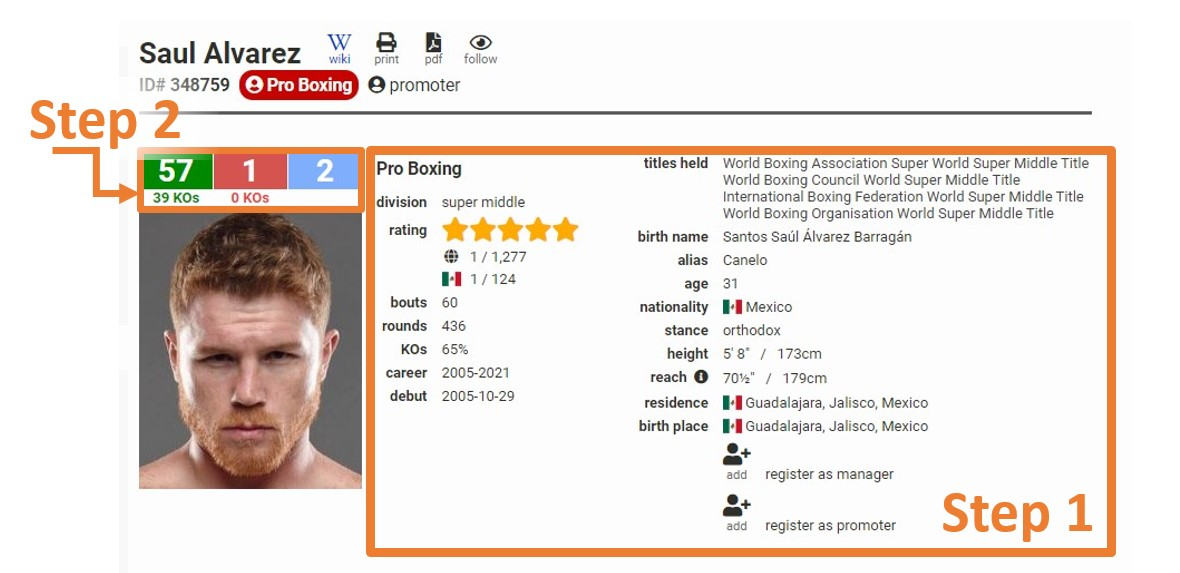

Trzecia petla w kodzie pobiera dane ze strony głownej gdzie dostepne są dane z punktami w rankingu ogólnym oraz "kolorowe kwadraciki". W tych kolorowych kwadracikach zapisana jest informacja o ostatnich sześciu stoczonych walkach. 
Sąt to bardzo istotne informacje ponieważ głowny scoring posłuży mi za Y natiomiast z ostatnich 6 walk stworze dodatkowy rating- moim zdaniuem pomocny z punktu widzenia przedykcji ratingu - Ale! Przekonamy się! 

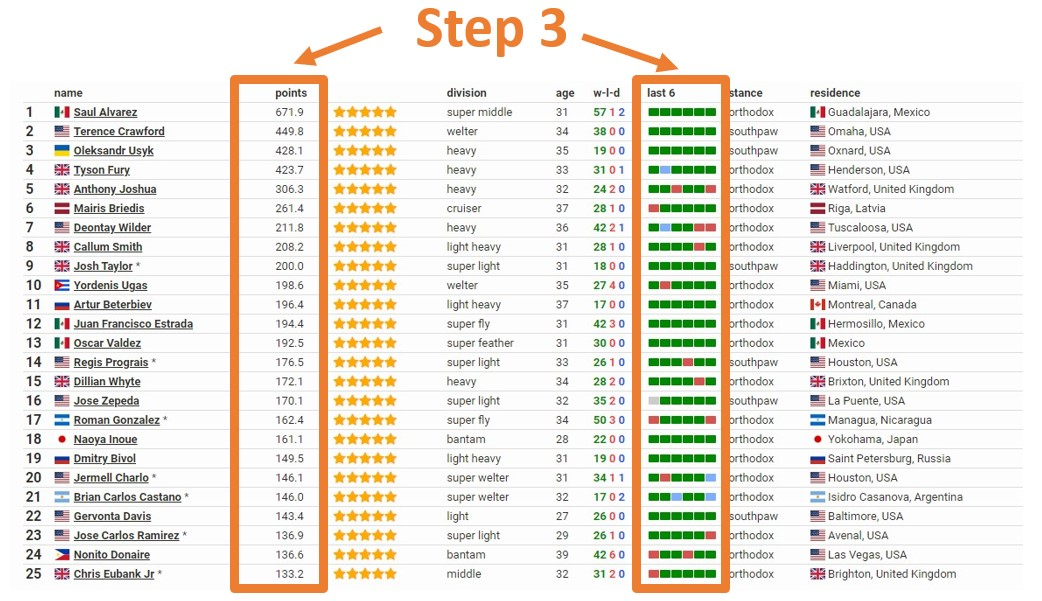

Psiadając zebrane dane w formie trzech osobnych dataframeów łącze je i czyszę do przystępnej postaci. Plik z kodem znajduje się na githubie w poniższej lokalizacji: 
https://github.com/karolbujnowski23/BoxRec_analysis/blob/main/BoxrecWS_deepFinal.R

Mając tak spreparowane dane przechodzę do Jupiternotebooka gdzie bede przeprowadzał przygotowanie danych, ich analizę oraz próbę stworzenia modelu przewidującego punktację rankingową. 

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

In [3]:
# ustawienia pozwalajace wyświetlac wszystkie kolumny z dataframeu
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Wczytuję dane wcześniej przygotowane przy pomocy kodu w R
br_active= pd.read_csv('active boxers/results_grandtotal_active.csv')
br_active.head()

,boxerID,wins,defeats,draws,wins_by_KO,defeats_by_KO,Pro.Boxing,division,rating_word,rating_native,bouts,rounds,KOs,career,debut,titles.held,birth.name,alias,age,nationality,stance,height,reach,residence,birth.place,manager.agent,promoter,MMA,boxer,points,last1,last2,last3,last4,last5,last6
0,5745,97,5,0,62 KOs,2 KOs,Pro Boxing,light heavy,"154 / 1,053",2 / 13,102,sign in to view,sign in to view,1994-2021,1994-05-18,NaN,Sirimongkhon Iamthuam,Sirimongkol Singwancha,44.0,Thailand,orthodox,5' 6” / 168cm,72” / 183cm,"Pathum Thani, Thailand","Pathum Thani, Thailand",NaN,NaN,NaN,Sirimongkhon Iamthuam,0.481,L,W,L,W,W,L
1,6283,10,35,2,3 KOs,11 KOs,Pro Boxing,fly,470 / 565,135 / 154,47,sign in to view,sign in to view,1989-2021,1989-01-20,NaN,NaN,Alche,50.0,Mexico,southpaw,5' 6” / 168cm,NaN,"Guadalajara, Jalisco, Mexico","Zapopan, Jalisco, Mexico",NaN,NaN,NaN,Jesus Jimenez Ruiz,0.001,L,L,L,L,L,L
2,6522,54,30,0,41 KOs,16 KOs,Pro Boxing,heavy,"274 / 1,222",21 / 46,85,sign in to view,sign in to view,1995-2021,1995-10-21,NaN,Daniel Peter Williams,Brixton Bomber,48.0,United Kingdom,orthodox,6' 3” / 191cm,79” / 201cm,"Brixton, London, United Kingdom","Brixton, London, United Kingdom",NaN,NaN,NaN,Danny Williams\r\n *,0.105,W,L,L,W,L,L
3,7126,5,24,0,4 KOs,19 KOs,Pro Boxing,super welter,"1,434 / 1,756",195 / 246,29,sign in to view,sign in to view,1989-2021,1989-11-30,NaN,Jesus Javier Arce Sarmiento,Lobito,49.0,Mexico,NaN,NaN,NaN,"Los Mochis, Sinaloa, Mexico",NaN,NaN,NaN,NaN,Jesus Arce Sarmiento,0.000,L,L,L,L,L,L
4,7345,5,42,0,4 KOs,30 KOs,Pro Boxing,light heavy,"643 / 1,053",11 / 18,47,sign in to view,sign in to view,1993-2021,1993-10-01,NaN,NaN,NaN,51.0,Colombia,NaN,5' 5” / 165cm,NaN,"Arboletes, Colombia","Arboletes, Colombia",NaN,NaN,NaN,Miguel Angel Suarez,0.002,L,L,L,L,L,L


In [5]:
#czyszczenie danych
# usuwam kolumny które nie maja znaczących informacji
br_active_cleaned= br_active.drop(columns=['KOs','rounds'])
# rozdzielam kolumny ktore mają zduplikowane przedzielone separatorem 
br_active_cleaned[['height inch', 'height cm']]= br_active_cleaned['height'].str.split(' / ', 1, expand=True)
br_active_cleaned[['reach inch', 'reach cm']]= br_active_cleaned['reach'].str.split(' / ', 1, expand=True)
br_active_cleaned[['rating_world_position', 'rating_world_category']]= br_active_cleaned['rating_word'].str.split(' / ', 1, expand=True).replace(',','', regex=True)
br_active_cleaned[['rating_native_position', 'rating_native_category']]= br_active_cleaned['rating_native'].str.split(' / ', 1, expand=True).replace(',','', regex=True)
br_active_cleaned[['career start', 'career edge']]= br_active_cleaned['career'].str.split('-', 1, expand=True)
# sprowadzam dane do postaci numerycznej
br_active_cleaned['reach cm']= br_active_cleaned['reach cm'].str.extract(r'([0-9]+)')
br_active_cleaned['height cm']= br_active_cleaned['height cm'].str.extract(r'([0-9]+)')
br_active_cleaned['wins_by_KO']= br_active_cleaned['wins_by_KO'].str.extract(r'([0-9]+)')
br_active_cleaned['defeats_by_KO']= br_active_cleaned['defeats_by_KO'].str.extract(r'([0-9]+)')

# definiuję typy danych dla kolumn numerycznych
br_active_cleaned = br_active_cleaned.astype({'rating_world_position':'float',
                                              'rating_native_position':'float',
                                              'reach cm':'float',
                                              'height cm':'float',
                                              'wins':'float',
                                              'defeats':'float',
                                              'draws':'float',
                                              'bouts':'float',
                                              'wins_by_KO':'float',
                                              'defeats_by_KO':'float',
                                              'age':'float',
                                              'points':'float'})

In [6]:
# Obliczam tzw KO ratio dla poszczególnych pięściarzy - czynnik używany wykorzystiwany przez dziennikarzy sportowych
br_active_cleaned['KOWratio'] = (br_active_cleaned['wins_by_KO']/br_active_cleaned['bouts']).round(4).fillna(0)
br_active_cleaned['KOWPratio'] = (br_active_cleaned['wins_by_KO']/br_active_cleaned['wins']).round(4).fillna(0)
br_active_cleaned['KODratio'] = (br_active_cleaned['defeats_by_KO']/br_active_cleaned['bouts']).round(4).fillna(0)
br_active_cleaned['KODPratio'] = (br_active_cleaned['defeats_by_KO']/br_active_cleaned['defeats']).round(4).fillna(0)


In [7]:
# Kolumny last1', 'last2','last3', 'last4', 'last5', 'last6' zawierają werdykt ostatnich 6 walk danego zawodnika. 
# W - win, L- loss, D- draw, NC- no contest, B- blank 
# zamieniam oznaczenia alfabetyczne na liczbowe nadając im odpowiednie wagi. 
# W myśl twierdzenia "zawodnik jest tak dobry jak jego 3 ostatnie walki" ostatnia stoczona walka ma najwyższą wage 
# następnie z każda kolejna walka wstecz ma mniejszą wartość 

def lastone (i):
    if (i=="W"):
        return 6
    elif (i=="D"):
        return 5
    elif (i=="L"):
        return 3
    elif (i=='NC'):
        return 1
    elif (i=='B'):
        return 0
    else:
        return "nan"

def lasttwo (i):
    if (i=="W"):
        return 5
    elif (i=="D"):
        return 4
    elif (i=="L"):
        return 2
    elif (i=='NC'):
        return 1
    elif (i=='B'):
        return 0
    else:
        return "nan"    

def lastthree (i):
    if (i=="W"):
        return 4
    elif (i=="D"):
        return 3
    elif (i=="L"):
        return 1
    elif (i=='NC'):
        return 0
    elif (i=='B'):
        return 0
    else:
        return "nan"    
    
def lastfour (i):
    if (i=="W"):
        return 3
    elif (i=="D"):
        return 2
    elif (i=="L"):
        return 0
    elif (i=='NC'):
        return 0
    elif (i=='B'):
        return 0
    else:
        return "nan"    

br_active_cleaned['last6V']= [lastone(i) for i in br_active_cleaned[['last6']].values]     
br_active_cleaned['last5V']= [lasttwo(i) for i in br_active_cleaned[['last5']].values]  
br_active_cleaned['last4V']= [lastthree(i) for i in br_active_cleaned[['last4']].values] 
br_active_cleaned['last3V']= [lastfour(i) for i in br_active_cleaned[['last3']].values] 
br_active_cleaned['last2V']= [lastfour(i) for i in br_active_cleaned[['last2']].values]
br_active_cleaned['last1V']= [lastfour(i) for i in br_active_cleaned[['last1']].values] 

# sumuję wszystkie kolumny tworząc score ostatnich 6 walk
br_active_cleaned['last6Fwec']= br_active_cleaned['last1V']+br_active_cleaned['last2V']+br_active_cleaned['last3V']+br_active_cleaned['last4V']+br_active_cleaned['last5V']+br_active_cleaned['last6V']

# obliczam czas trwania kariery w dniach
# br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['career start'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days
br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['debut'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days

In [8]:
# obliczam czas trwania kariery w dniach
br_active_cleaned['debut'] = pd.to_datetime(br_active_cleaned['debut'])
# br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['career start'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days
br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['debut'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days

In [9]:
# oznaczam zawodników z backgroundem MMA 
br_active_cleaned_mmaf = br_active_cleaned.dropna(subset=['MMA'])
br_active_cleaned_mman = br_active_cleaned[br_active_cleaned['MMA'].isnull()]
br_active_cleaned_mman=br_active_cleaned_mman.assign(MMA='N')
br_active_cleaned_mmaf=br_active_cleaned_mmaf.assign(MMA='Y')
br_active_cleaned= pd.concat([br_active_cleaned_mmaf,br_active_cleaned_mman], axis=0)

In [10]:
br_active_cleaned.columns

Index(['boxerID', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
       'Pro.Boxing', 'division', 'rating_word', 'rating_native', 'bouts',
       'career', 'debut', 'titles.held', 'birth.name', 'alias', 'age',
       'nationality', 'stance', 'height', 'reach', 'residence', 'birth.place',
       'manager.agent', 'promoter', 'MMA', 'boxer', 'points', 'last1', 'last2',
       'last3', 'last4', 'last5', 'last6', 'height inch', 'height cm',
       'reach inch', 'reach cm', 'rating_world_position',
       'rating_world_category', 'rating_native_position',
       'rating_native_category', 'career start', 'career edge', 'KOWratio',
       'KOWPratio', 'KODratio', 'KODPratio', 'last6V', 'last5V', 'last4V',
       'last3V', 'last2V', 'last1V', 'last6Fwec', 'career_period'],
      dtype='object')

In [11]:
# Tworzę tabelę do analizy 
# wybieram kolumny z ktorych bede chcial skorzystać
work_atributes = ['boxerID','age','wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
 'division', 'bouts','debut','career edge','career_period',
 'nationality', 'stance', 'MMA', 'boxer','height cm','reach cm',
 'points','rating_world_position','rating_world_category', 'rating_native_position','rating_native_category',
 'last1', 'last2','last3', 'last4', 'last5', 'last6','titles.held',
 'KOWratio','KOWPratio','KODratio','KODPratio','last6Fwec']

# Tworzę nowy DF do analizy
br_active_work= br_active_cleaned.loc[:,work_atributes]

br_active_work.head()

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,debut,career edge,career_period,nationality,stance,MMA,boxer,height cm,reach cm,points,rating_world_position,rating_world_category,rating_native_position,rating_native_category,last1,last2,last3,last4,last5,last6,titles.held,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
37,19280,44.0,6.0,34.0,1.0,5.0,29.0,super welter,41.0,1998-02-08,2021,8363,USA,orthodox,Y,Starr Johnson,185.0,NaN,0.000,1453.0,1756,254.0,289,L,L,L,L,L,L,NaN,0.1220,0.8333,0.7073,0.8529,6
379,291908,37.0,34.0,2.0,2.0,25.0,1.0,super middle,38.0,2005-01-27,2021,5818,USA,orthodox,Y,Anthony Dirrell,188.0,189.0,19.540,15.0,1281,5.0,232,W,W,W,L,D,W,NaN,0.6579,0.7353,0.0263,0.5000,20
2450,609451,39.0,1.0,15.0,1.0,1.0,6.0,middle,17.0,2012-04-12,2021,3186,USA,orthodox,Y,Estevan Payan,178.0,183.0,0.002,911.0,1367,173.0,251,L,L,L,L,L,L,NaN,0.0588,1.0000,0.3529,0.4000,6
2632,623357,33.0,14.0,19.0,3.0,8.0,8.0,super light,38.0,2012-09-15,2021,3030,USA,orthodox,Y,Rondale Hubbert\r\n *,173.0,NaN,0.097,533.0,1896,86.0,295,L,L,L,D,W,L,NaN,0.2105,0.5714,0.2105,0.4211,11
2714,628451,30.0,23.0,3.0,1.0,12.0,0.0,super feather,27.0,2012-10-06,2021,3009,USA,orthodox,Y,Andy Vences,174.0,183.0,12.590,24.0,1400,7.0,182,W,W,L,W,L,L,NaN,0.4444,0.5217,0.0000,0.0000,15


In [12]:
# Sprawdzam gdzie nie ma danych i ile danych brakuje 
braw = br_active_work.copy()
braw.isna().sum().sort_values(ascending=True)

boxerID                       0
KODratio                      0
KOWPratio                     0
KOWratio                      0
last6                         0
last5                         0
last4                         0
last3                         0
last2                         0
last1                         0
points                        0
KODPratio                     0
boxer                         0
MMA                           0
last6Fwec                     0
bouts                         0
wins                          0
career_period                 0
career edge                   0
defeats                       0
draws                         0
debut                         0
wins_by_KO                    0
defeats_by_KO                 0
rating_world_position       374
rating_world_category       374
division                    374
nationality                 715
rating_native_category     1026
rating_native_position     1026
age                        1917
stance  

In [13]:
no_rows = braw.shape[0]
(braw.isnull().sum()/no_rows).sort_values(ascending=True)

boxerID                   0.000000
KODratio                  0.000000
KOWPratio                 0.000000
KOWratio                  0.000000
last6                     0.000000
last5                     0.000000
last4                     0.000000
last3                     0.000000
last2                     0.000000
last1                     0.000000
points                    0.000000
KODPratio                 0.000000
boxer                     0.000000
MMA                       0.000000
last6Fwec                 0.000000
bouts                     0.000000
wins                      0.000000
career_period             0.000000
career edge               0.000000
defeats                   0.000000
draws                     0.000000
debut                     0.000000
wins_by_KO                0.000000
defeats_by_KO             0.000000
rating_world_position     0.018653
rating_world_category     0.018653
division                  0.018653
nationality               0.035661
rating_native_catego

In [14]:
# wyrzucam kolumny z najwiekszymi brakami danych
braw= braw.drop(columns= ['titles.held','reach cm','height cm','stance'])
# wyrzucam braki w danych 
braw= braw.dropna()
braw.shape

(17490, 31)

In [15]:
# sprawdzam podstawowe miary statystyczne zbioru danych
braw.describe().round(2)

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,bouts,career_period,points,rating_world_position,rating_native_position,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
count,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00
mean,817282.31,27.72,6.36,4.18,0.44,3.55,2.02,11.03,1442.24,1.36,666.52,53.27,0.31,0.42,0.22,0.35,12.51
std,197815.56,6.07,8.00,7.92,0.89,5.21,4.11,12.95,1613.40,11.40,465.50,73.01,0.31,0.37,0.32,0.40,6.70
min,5745.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,720109.25,23.00,1.00,0.00,0.00,0.00,0.00,2.00,274.00,0.00,276.00,6.00,0.00,0.00,0.00,0.00,6.00
50%,850765.00,27.00,3.00,1.00,0.00,1.00,1.00,6.00,825.00,0.01,592.00,20.00,0.24,0.44,0.05,0.20,12.00
75%,991872.00,31.00,9.00,5.00,1.00,5.00,2.00,15.00,2085.00,0.19,986.00,68.00,0.50,0.73,0.33,0.70,18.00
max,1061024.00,59.00,97.00,221.00,12.00,62.00,66.00,248.00,11669.00,680.70,1947.00,381.00,1.00,1.00,1.00,1.00,24.00


In [16]:
#usuwam dane powyżej 99 percentylu
braw = braw[braw.age < np.percentile(braw.age,99)]
braw = braw[braw.wins < np.percentile(braw.wins,99)]
braw = braw[braw.defeats < np.percentile(braw.defeats,99)]
braw = braw[braw.draws < np.percentile(braw.draws,99)]
braw = braw[braw.wins_by_KO < np.percentile(braw.wins_by_KO,99)]
braw = braw[braw.defeats_by_KO < np.percentile(braw.defeats_by_KO,99)]
braw = braw[braw.bouts < np.percentile(braw.bouts,99)]
braw = braw[braw.points < np.percentile(braw.points,99)]
braw = braw[braw.rating_world_position < np.percentile(braw.rating_world_position,99)]
braw = braw[braw.rating_native_position < np.percentile(braw.rating_native_position,99)]
braw = braw[braw.KODPratio < np.percentile(braw.KODPratio,99)]
braw = braw[braw.KOWPratio < np.percentile(braw.KODPratio,99)]
braw = braw[braw.KOWratio < np.percentile(braw.KODPratio,99)]
braw = braw[braw.KODratio < np.percentile(braw.KODPratio,99)]
braw = braw[braw.last6Fwec < np.percentile(braw.last6Fwec,99)]

In [17]:
# sprawdzam podstawowe miary statystyczne zbioru danych
braw.describe().round(2)

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,bouts,career_period,points,rating_world_position,rating_native_position,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
count,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00,9142.00
mean,818786.61,27.40,5.67,3.76,0.49,2.63,1.46,9.95,1402.49,0.50,620.42,47.46,0.21,0.30,0.12,0.21,12.49
std,173455.47,5.49,6.13,4.78,0.76,3.63,2.51,8.96,1394.85,1.59,421.77,61.59,0.22,0.28,0.18,0.27,5.77
min,14259.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,718680.50,23.00,1.00,0.00,0.00,0.00,0.00,3.00,296.50,0.00,275.00,7.00,0.00,0.00,0.00,0.00,6.00
50%,838546.00,27.00,4.00,2.00,0.00,1.00,0.00,7.00,959.00,0.01,544.00,20.00,0.16,0.33,0.00,0.00,12.00
75%,969307.75,31.00,8.00,5.00,1.00,4.00,2.00,15.00,2106.00,0.18,889.00,63.00,0.38,0.50,0.18,0.50,18.00
max,1061017.00,44.00,33.00,32.00,3.00,19.00,15.00,38.00,8434.00,17.29,1817.00,308.00,0.80,0.85,0.85,0.93,23.00


In [18]:
# po usunięciu danych powyzej 99 percentyla  wmiejscu zer w zbiorze pojawily wartosci "-inf" ktore należy ponownie zerami
braw["points"] = braw["points"].replace(-np.inf,0)
print(braw['points'])

2632      0.097
2714     12.590
2955      0.010
3052      0.005
3172      1.793
          ...  
20027     0.003
20029     0.001
20033     0.001
20034     0.000
20045     0.000
Name: points, Length: 9142, dtype: float64


<AxesSubplot:xlabel='points', ylabel='rating_world_position'>

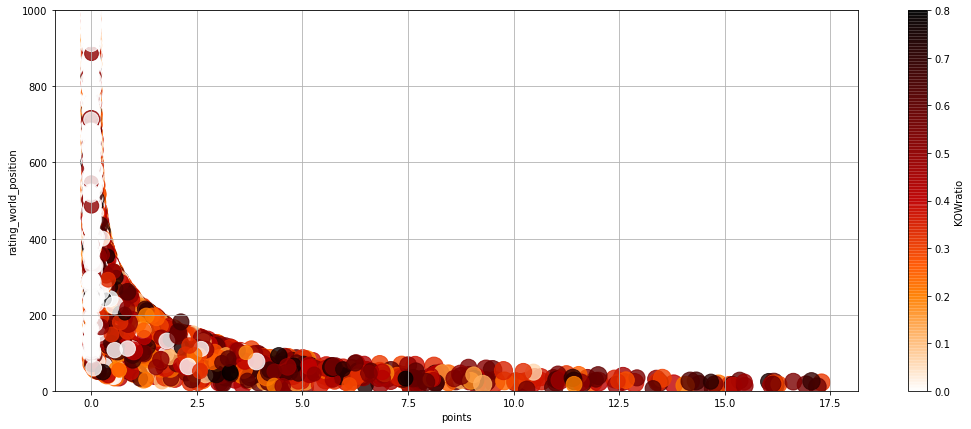

In [19]:
braw.plot(kind="scatter", x="points", y="rating_world_position", alpha=0.8, figsize=(18,7),ylim=(0,1000),
        c="KOWratio",s=[n*10 for n in braw["age"]], cmap="gist_heat_r",grid=True, colorbar=True, sharex=False)

<AxesSubplot:xlabel='points', ylabel='wins'>

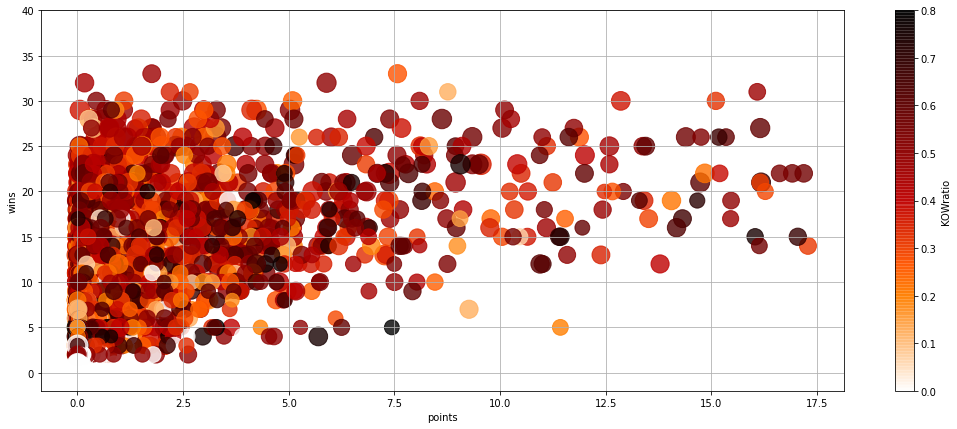

In [20]:
braw.plot(kind="scatter", x="points", y="wins", alpha=0.8, figsize=(18,7),ylim=(-2,40),
        c="KOWratio",s=[n*10 for n in braw["age"]], cmap="gist_heat_r",grid=True, colorbar=True, sharex=False)

<AxesSubplot:title={'center':'Division '}, ylabel='division'>

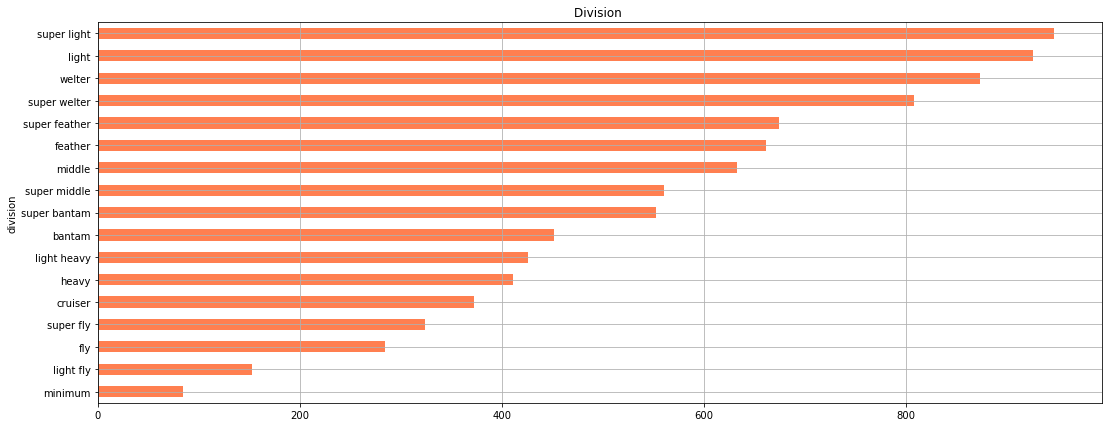

In [21]:
# Sprawdzam w ktorej kategorii jest najwięcej zawodników
divplot=braw.loc[:,['boxerID','division']].groupby(['division']).count().reset_index().sort_values(by=['boxerID'], ascending=True)
divplot.plot(kind='barh', x='division', y='boxerID',  figsize=(18,7), legend=False, grid=True, color='coral', title='Division ')
# sns.countplot(x="division", data = braw, hue='division', palette="muted")

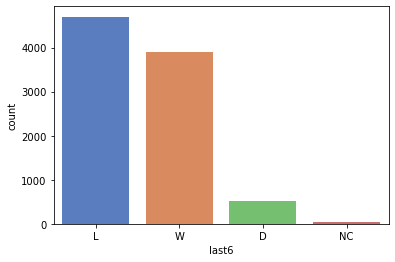

In [22]:
# sprawdzam wartości w kolumnie zawierającej informacje na temat ostatniej stoczonej walki
sns.countplot(x="last6", data = braw, palette="muted")
plt.show()

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

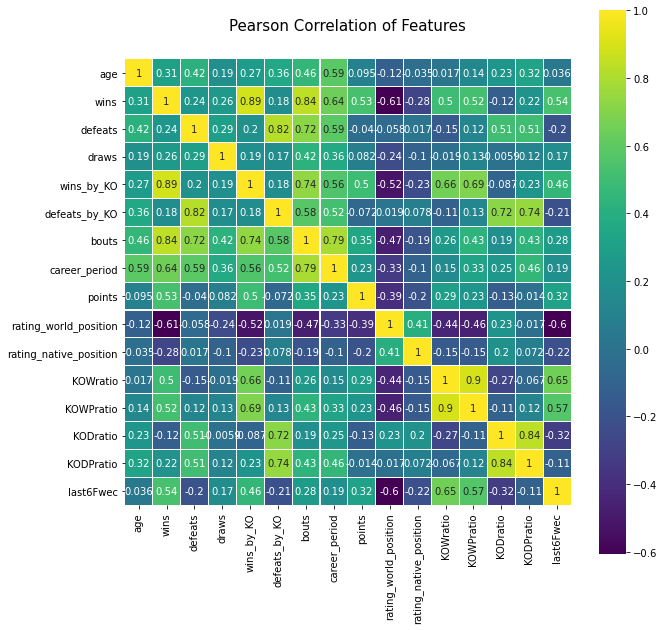

In [23]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(braw.drop(columns=['boxerID']).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)

In [24]:
# tworze prosty model regressi liniowej
# definiuje zmienne
X = np.c_[braw['wins']]
y = np.c_[braw['points']]
# wybieram model
model = sklearn.linear_model.LinearRegression()
# trenuje model
model.fit(X, y)

LinearRegression()

In [25]:
pred= model.predict(X)
pred_reg= pd.concat([pd.DataFrame(pred, columns= ['pred_reg']),
                     pd.DataFrame(y, columns= ['points']),
                     pd.DataFrame(X, columns= ['wins'])],axis=1)

In [26]:
# from sklearn.metrics import confusion_matrix,classification_report
# print(classification_report(y, model.predict(X)))
# print(confusion_matrix(y_train, rfr.predict(X_train)))
# plot_confusion_matrix(rfr, X_train, y_train)
print(model.score(X,y,sample_weight=None)) # returns R^2 of 

0.27686362638822126


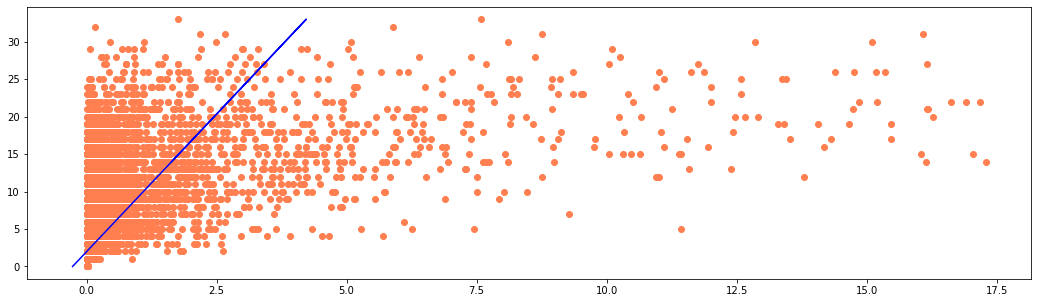

In [27]:
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(pred_reg['points'],pred_reg['wins'], c='coral' )
ax1.plot(pred_reg['pred_reg'],pred_reg['wins'], c='b' )

# Random Forest Regressor

In [28]:
braw["points"] = braw["points"].replace(-np.inf,0)
print(braw['points'])

2632      0.097
2714     12.590
2955      0.010
3052      0.005
3172      1.793
          ...  
20027     0.003
20029     0.001
20033     0.001
20034     0.000
20045     0.000
Name: points, Length: 9142, dtype: float64


Do normalizacji danych kategorycznych wykorzystam One Hot Encoder. w tym celu należy podzielic próbkę na zbior zawierajacy tylko dane kategoryczne oraz analogicznie tylko dane numeryczne.

In [29]:
# Wyznaczam target - wartością ktorą chcę przewidzieć jest rating z kolumny 'points'
X= braw.drop(['points', 'rating_native_position', 'rating_world_position','boxerID', 'debut', 'career edge','boxer'],axis=1)
y= braw['points']

In [30]:
X.head()

,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,career_period,nationality,MMA,rating_world_category,rating_native_category,last1,last2,last3,last4,last5,last6,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
2632,33.0,14.0,19.0,3.0,8.0,8.0,super light,38.0,3030,USA,Y,1896,295,L,L,L,D,W,L,0.2105,0.5714,0.2105,0.4211,11
2714,30.0,23.0,3.0,1.0,12.0,0.0,super feather,27.0,3009,USA,Y,1400,182,W,W,L,W,L,L,0.4444,0.5217,0.0000,0.0000,15
2955,30.0,8.0,19.0,1.0,4.0,7.0,middle,28.0,2869,USA,Y,1367,251,L,L,L,L,L,L,0.1429,0.5000,0.2500,0.3684,6
3052,36.0,1.0,10.0,2.0,0.0,5.0,super light,14.0,2799,USA,Y,1896,295,L,NC,L,L,L,L,0.0000,0.0000,0.3571,0.5000,6
3172,30.0,8.0,2.0,0.0,5.0,1.0,welter,10.0,3031,USA,Y,1824,381,W,L,W,W,L,W,0.5000,0.6250,0.1000,0.5000,18


In [31]:
X.shape

(9142, 24)

In [32]:
# dziele zbior X na XN zawierajacy dane numeryczne, XC- zawierający dane kategoryczne
Nc= ['age', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO','bouts', 'career_period','KOWratio', 'KOWPratio', 'KODratio',
       'KODPratio', 'last6Fwec']
XN = X.loc[:,Nc]
XC= X.drop(Nc,axis=1)
print(XC.shape,XN.shape)

(9142, 11) (9142, 13)


In [33]:
# # Dane kategoryczne należy skonwertowac do numerycznych 
# from sklearn.preprocessing import OneHotEncoder 
# ohe = OneHotEncoder(handle_unknown='ignore')

# # cat_cols=['division','nationality', 'MMA','rating_world_category', 'rating_native_category', 'last1', 'last2',
# #           'last3', 'last4', 'last5', 'last6']
# ohe.fit(XC)
# XCt = ohe.transform(XC)

In [34]:
# # Dane kategoryczne należy skonwertowac do numerycznych - używam get_dummies
XCt= pd.get_dummies(XC)
XCt.shape

(9142, 307)

In [35]:
Xt= XN.join(XCt)
Xt.shape # zgadza sie liczba kolumn - kolumn numerycznych było 13 (+307=320)

(9142, 320)

In [36]:
# mając juz przygotowana tabele z zawierającą przekszatłcone dane kategoryczne wraz z danymi numerycznymi
# należy znormatyzowac dane - w tym celu zastosuje z-score. 
# Funkcja z-score jako input przyjmuje dane w formie macierzy dlatego w pierwszym krotu zamieniam df na macierz 
Xt_arr= Xt.to_numpy()
Xt_arr.shape

(9142, 320)

In [37]:
from scipy import stats
Xt_zs = stats.zscore(Xt_arr)
Xt_zs.shape

(9142, 320)

In [38]:
# wprowadzam podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size = 0.33, random_state = 42)

In [39]:
X_train.shape, X_test.shape

((6125, 320), (3017, 320))

In [40]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
# sprawdzam dokładnosc modelu dla zbioru treningowego
rfr_score= rfr.score(X_train,y_train,sample_weight=None)
print(rfr_score)

0.9113669291478912


In [41]:
# sprawdzam dokładnosc modelu dla zbioru testowego
rfr_predict= rfr.predict(X_test)

In [42]:
rfr_score= rfr.score(X_test,y_test,sample_weight=None)
print(rfr_score)

0.4394362798034409


# Mean squared error

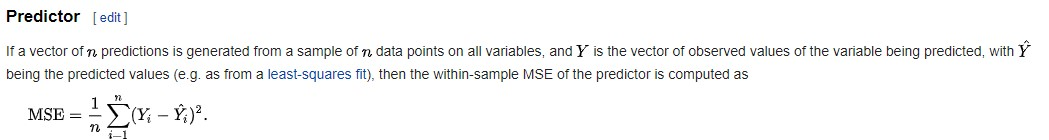

In [43]:
# Błąd średniokwadratowy, średni błąd kwadratowy, MSE dla zbioru treningowego
from sklearn.metrics import mean_squared_error
predicted = rfr.predict(X_train)
mean_squared_error(y_train, predicted)

0.2186194663403163

In [44]:
# Błąd średniokwadratowy, średni błąd kwadratowy, MSE dla zbioru testowego
from sklearn.metrics import mean_squared_error
predicted = rfr.predict(X_test)
mean_squared_error(y_test, predicted)

1.4636990302779027

# Explained Variance as a Performance Metric
For now, we use explained variance,  EV , as a metric to evaluate the performance of a model:

EV=1−Var(y−y¯)Var(y) 
where  y  is the true price,  y¯  is the estimated price from the model, and  Var(⋅)  is the variance. The  y¯  estimates come from predictions made on the data witheld from training in each round of cross-validation. See: http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

In [45]:
from sklearn.model_selection import cross_val_score
scores_rfr = cross_val_score(rfr,X_train,y_train,cv=10,scoring='explained_variance')

# Est. explained variance: %0.2f (+/- %0.2f)
print(scores_rfr.mean(), scores_rfr.std() * 2)

0.39043877266938554 0.15690911595362156


 Model nie dziala poprawnie i jest przetrenowany. W celu jego poprawy sprobuję ograniczyc liczbę estymatorów.
 W tym celu sprawdzę czy ograniczenie ilości estymatorów znacząco popawi jakość modelu

In [46]:
# za pomocąpetyli bede uruchamiac model kolejno dla 10,20,50,70,80 drzew. 
# wyniki podsumuję w tabeli

estimators= [10,20,50,70,80]
rows=[]
for i in estimators:
    rfr = RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
    rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
    predicted = rfr.predict(X_test)
    mse_test= mean_squared_error(y_test, predicted)
    rows.append([i, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results= pd.DataFrame(rows, columns= ['estimators','train score', 'test_score','mse_test'] )

In [47]:
rfr_results.sort_values(by="mse_test", ascending=True)

,estimators,train score,test_score,mse_test
4,80,0.912641,0.431052,1.485592
1,20,0.889988,0.429508,1.489624
3,70,0.914413,0.423085,1.506394
2,50,0.914008,0.420425,1.513341
0,10,0.889907,0.393734,1.583033


Najmniejszy błąd wychodzi dla 70 drzew , ale to i tak niedostatecznie dobry wynik. Widać ze ilość estymatorów wpływa pozytywnie na jakość predykcji.

In [48]:
# sprawdzę czy wynik będzie lepszy dla zastsowania 200 i 300 drzew.
estimators= [200,300]
rows=[]
for i in estimators:
    rfr = RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
    rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
    predicted = rfr.predict(X_test)
    mse_test= mean_squared_error(y_test, predicted)
    rows.append([i, rfr_train_score,rfr_test_score,mse_test])
    
rfr_results01= pd.DataFrame(rows, columns= ['estimators','train score', 'test_score','mse_test'] )
rfr_results01.sort_values(by="mse_test", ascending=True)

,estimators,train score,test_score,mse_test
0,200,0.915564,0.433721,1.478623
1,300,0.915611,0.431402,1.484678


In [49]:
rfr_results100 = pd.DataFrame({"estimators": [100], "train score": [0.9126241777917824], "test_score": [0.4393947330399387],"mse_test": [1.4638075138548066]})
rfr_results = pd.concat([rfr_results100,rfr_results,rfr_results01])
rfr_results.sort_values(by="mse_test", ascending=True).drop_duplicates()
# rfr_results100

,estimators,train score,test_score,mse_test
0,100,0.912624,0.439395,1.463808
0,200,0.915564,0.433721,1.478623
1,300,0.915611,0.431402,1.484678
4,80,0.912641,0.431052,1.485592
1,20,0.889988,0.429508,1.489624
3,70,0.914413,0.423085,1.506394
2,50,0.914008,0.420425,1.513341
0,10,0.889907,0.393734,1.583033


Prediction score dla 100 estymatorów wynosił 0.4393947330399387 stąd wniosek, że dalsze powiększanie lasu drzew nie przyniesie poprawy jakościo rzewidywania na próbce testowej. 

W nastepnych krokach spróbuję zoptymalizowac ilosc zmiennych wejściowych aby poprawic jakosc predykcji i zapobiec przeuczeniu modelu

Za pomocą dostepnej biblioteki sklearn.feature_selection zamierzam dokonac weryfikacji zmiennych pod ich skorelowania miedzy sobą.

In [50]:
# przygotowuję dane w celu zaaplikowania do modelu
X= braw.drop(['points', 'rating_native_position', 'rating_world_position','boxerID', 'debut', 'career edge','boxer'],axis=1)
y= braw['points']

In [51]:
X.columns

Index(['age', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
       'division', 'bouts', 'career_period', 'nationality', 'MMA',
       'rating_world_category', 'rating_native_category', 'last1', 'last2',
       'last3', 'last4', 'last5', 'last6', 'KOWratio', 'KOWPratio', 'KODratio',
       'KODPratio', 'last6Fwec'],
      dtype='object')

In [52]:
# zamieniam kolumny na dane kategoryczne na potrzeby algorytmu scoringowego ważność poszczególnych kolumn
braw_c= X.copy()
braw_c['division']= X['division'].astype('category').cat.codes
braw_c['MMA']= X['MMA'].astype('category').cat.codes
braw_c['last1']= X['last1'].astype('category').cat.codes
braw_c['last2']= X['last2'].astype('category').cat.codes
braw_c['last3']= X['last3'].astype('category').cat.codes
braw_c['last4']= X['last4'].astype('category').cat.codes
braw_c['last5']= X['last5'].astype('category').cat.codes
braw_c['last6']= X['last6'].astype('category').cat.codes
braw_c['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
braw_c['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
braw_c['nationality']= X['nationality'].astype('category').cat.codes
braw_c.head()

,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,career_period,nationality,MMA,rating_world_category,rating_native_category,last1,last2,last3,last4,last5,last6,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
2632,33.0,14.0,19.0,3.0,8.0,8.0,13,38.0,3030,124,1,13,48,2,2,2,1,4,1,0.2105,0.5714,0.2105,0.4211,11
2714,30.0,23.0,3.0,1.0,12.0,0.0,11,27.0,3009,124,1,8,24,4,4,2,4,2,1,0.4444,0.5217,0.0000,0.0000,15
2955,30.0,8.0,19.0,1.0,4.0,7.0,8,28.0,2869,124,1,7,38,2,2,2,2,2,1,0.1429,0.5000,0.2500,0.3684,6
3052,36.0,1.0,10.0,2.0,0.0,5.0,13,14.0,2799,124,1,13,48,2,3,2,2,2,1,0.0000,0.0000,0.3571,0.5000,6
3172,30.0,8.0,2.0,0.0,5.0,1.0,16,10.0,3031,124,1,12,61,4,2,4,4,2,3,0.5000,0.6250,0.1000,0.5000,18


In [53]:
# feature selection library in scikit-learn
import sklearn.feature_selection as fs 
mir_result1 = fs.mutual_info_regression(braw_c, y)

In [54]:
included_features1 = braw_c.columns
feature_scores1 = []
for i in np.arange(len(included_features1)):
    feature_scores1.append([included_features1[i],mir_result1[i]])
    
sorted_scores1 = sorted(np.array(feature_scores1), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores1))

[['wins' '0.569770311945561']
 ['last6Fwec' '0.40289753657569527']
 ['wins_by_KO' '0.34569543611238984']
 ['KOWratio' '0.31088420150177587']
 ['KOWPratio' '0.31076376990980314']
 ['bouts' '0.2721555540824898']
 ['last1' '0.2300899160796015']
 ['KODratio' '0.22165830997386937']
 ['last2' '0.22159880183002434']
 ['last3' '0.2152661240673983']
 ['last4' '0.19919001700429817']
 ['career_period' '0.1683467356609487']
 ['last5' '0.15515833426175485']
 ['nationality' '0.10372553706937193']
 ['defeats' '0.10076324060605568']
 ['last6' '0.07631231006446137']
 ['rating_native_category' '0.06432475904034973']
 ['defeats_by_KO' '0.06257281189690822']
 ['age' '0.04781632531473967']
 ['draws' '0.0469009028059606']
 ['rating_world_category' '0.03809080000725018']
 ['KODPratio' '0.03750410183085329']
 ['division' '0.02962462838806168']
 ['MMA' '0.0']]


In [55]:
# przygotowuję listę zmiennych aby moc aplikowac te liste w dalszej czesci pracy
sorted_scores_df1= pd.DataFrame(sorted_scores1, columns=['sorted_column','importance_score'])
sorted_scores_df1= sorted_scores_df1.sort_values(by='importance_score', ascending=True)
sorted_scores_list1= sorted_scores_df1['sorted_column'].tolist()


Udało sie otrzymać scoring zmiennych. W celu wizualizacji wyniku tworzę wykres:

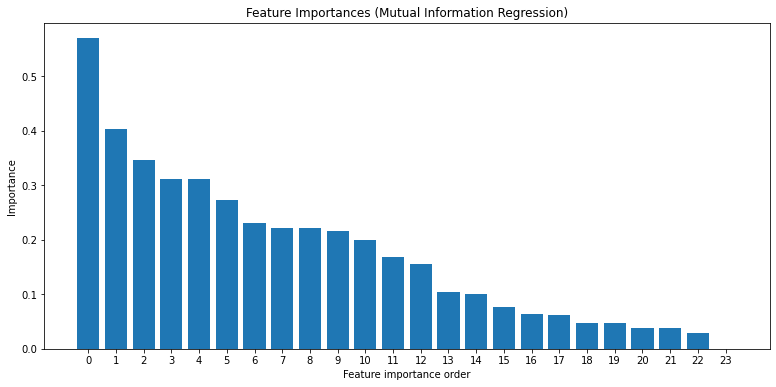

In [56]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features1))
plt.bar(ind,[float(i) for i in np.array(sorted_scores1)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
plt.xlabel('Feature importance order')
# plt.grid()
plt.show()

In [58]:
# Sprawdze jeszcze jak bedzie wyglądac rozkład dla formatowanych wcześniej danych Xt
mir_result = fs.mutual_info_regression(Xt, y)
included_features = Xt.columns
feature_scores = []
for i in np.arange(len(included_features)):
    feature_scores.append([included_features[i],mir_result[i]])
    
sorted_scores= sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

[['wins' '0.5753958312708001']
 ['last6Fwec' '0.4226705926313965']
 ['wins_by_KO' '0.34372074413009734']
 ['KOWPratio' '0.31122321057694347']
 ['KOWratio' '0.30028893374185106']
 ['bouts' '0.2683596282393639']
 ['KODratio' '0.21346425040942485']
 ['last2_B' '0.19076378399422467']
 ['last1_B' '0.17985600926779144']
 ['career_period' '0.17062004733165193']
 ['last3_B' '0.17020153051047515']
 ['last4_B' '0.16416432114974544']
 ['last2_W' '0.14655287386858573']
 ['last3_W' '0.1341578873026319']
 ['last1_W' '0.13163448489915952']
 ['last5_B' '0.10865179392579671']
 ['defeats' '0.10490377915679439']
 ['last4_W' '0.09845135413146133']
 ['last5_W' '0.07645517319549722']
 ['last6_W' '0.06917510753041922']
 ['last6_L' '0.06877930996149617']
 ['KODPratio' '0.06005467136443965']
 ['draws' '0.05666014803051178']
 ['age' '0.048951899951532596']
 ['defeats_by_KO' '0.047966087133289204']
 ['last4_NC' '0.0222015363837218']
 ['last6_D' '0.021830070008429292']
 ['rating_native_category_107' '0.0191835436

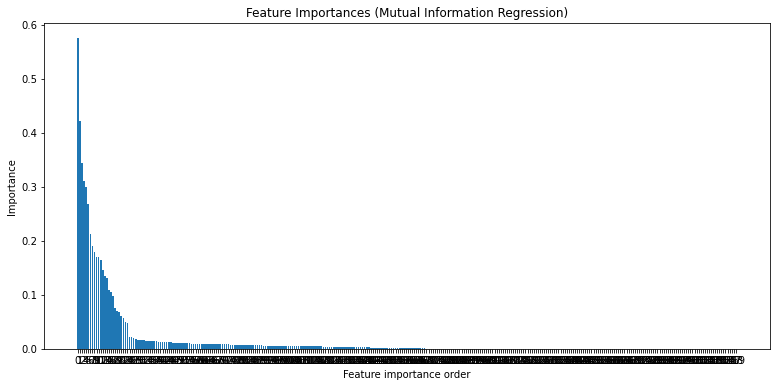

In [59]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
plt.xlabel('Feature importance order')
# plt.grid()
plt.show()

Przyjmuję strategię aby sprawdzić performance modelu w zależnosci od ilości zaaplikowanych zmiennych oraz ilości drzew.

Powtarzam procedure trenowania modelu zgodnie z przyjętą strategią

In [60]:
# przygotowuję listę zmiennych tak aby aplikowac co 4 zmienne 
sorted_scores_df= pd.DataFrame(sorted_scores, columns=['sorted_column','importance_score'])
sorted_scores_df= sorted_scores_df.sort_values(by='importance_score', ascending=True)
sorted_scores_list= sorted_scores_df['sorted_column'].tolist()
sorted_scores_list[:10]+['wins']

['last6_NC',
 'nationality_Israel',
 'nationality_Japan',
 'nationality_Kazakhstan',
 'nationality_Kenya',
 'nationality_Latvia',
 'nationality_Malawi',
 'nationality_Mexico',
 'nationality_Montenegro',
 'nationality_Mozambique',
 'wins']

In [61]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia estymatorów oraz jaka iloscia X model bedzie najbardziej efektywny
estimators= [10,20,50,70,80,100]
nfeatures = list(range(3,len(sorted_scores_list)+1, 10))
rows1=[]
for j in nfeatures:
    X= Xt.loc[:,(sorted_scores_list[:j]+['wins'])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy w stosunku 67% -zbior treningowy, 33% -zbior testowy
    # normalizacja zmiennych za pomocą OneHotEncoder
#     ohe.fit(X_train)
#     X_train = ohe.transform(X_train)
#     X_test = ohe.transform(X_test)
    # normalizacja danych za pomocą zscore
    Xt_arr= Xt.to_numpy()
    Xt_zs = stats.zscore(Xt_arr)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train, y_train)
        rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
        predicted = rfr.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)
        rows1.append([i,j, rfr_train_score,rfr_test_score,mse_test])

In [62]:
rfr_results1= pd.DataFrame(rows1, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results1.sort_values(by="mse_test", ascending=True)

,estimators,nfeatures,train score,test_score,mse_test
188,50,313,0.905125,0.416710,1.523039
182,50,303,0.900804,0.412772,1.533321
184,80,303,0.904240,0.411819,1.535812
191,100,313,0.914984,0.407318,1.547564
185,100,303,0.908199,0.407139,1.548031
...,...,...,...,...,...
66,10,113,0.659081,0.137296,2.252623
96,10,163,0.733981,0.133072,2.263653
36,10,63,0.518086,0.133055,2.263697
67,20,113,0.660040,0.132812,2.264333


Zastosowanie redukcji wymiarównie przyniosło wymiernego rezultatu. Model ma gorszą sprawność niż przy pierwszej próbie przy czym widać ze najlepsze rezultaty w tej metodzie osiągamys stosująć największą ilość zmiennych 

Text(0, 0.5, 'Prediction score on the TEST sample')

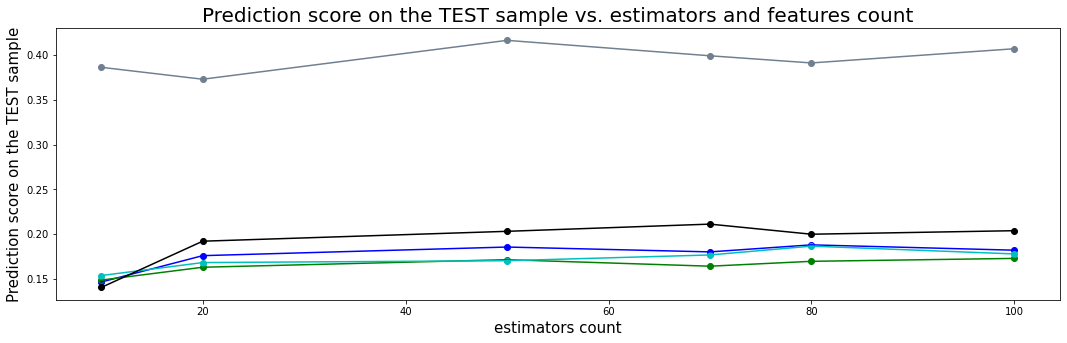

In [63]:
# wyrkes obrazujący jak zmienia sie dokładnośc predykcji w zależności od ilości drzew
rfr_results1_f50 = rfr_results1[rfr_results1['nfeatures'].isin(['53'])]
rfr_results1_f100 = rfr_results1[rfr_results1['nfeatures'].isin(['103'])]
rfr_results1_f150 = rfr_results1[rfr_results1['nfeatures'].isin(['153'])]
rfr_results1_f3130 = rfr_results1[rfr_results1['nfeatures'].isin(['203'])]
rfr_results1_f313 = rfr_results1[rfr_results1['nfeatures'].isin(['313'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results1_f50['estimators'],rfr_results1_f50['test_score'], c='b' )
ax1.plot(rfr_results1_f50['estimators'],rfr_results1_f50['test_score'], c='b' )
ax1.scatter(rfr_results1_f100['estimators'],rfr_results1_f100['test_score'], c='g' )
ax1.plot(rfr_results1_f100['estimators'],rfr_results1_f100['test_score'], c='g' )
ax1.scatter(rfr_results1_f150['estimators'],rfr_results1_f150['test_score'], c='c' )
ax1.plot(rfr_results1_f150['estimators'],rfr_results1_f150['test_score'], c='c' )
ax1.scatter(rfr_results1_f3130['estimators'],rfr_results1_f3130['test_score'], c='k' )
ax1.plot(rfr_results1_f3130['estimators'],rfr_results1_f3130['test_score'], c='k' )
ax1.scatter(rfr_results1_f313['estimators'],rfr_results1_f313['test_score'], c='slategray' )
ax1.plot(rfr_results1_f313['estimators'],rfr_results1_f313['test_score'], c='slategray' )

plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Text(0, 0.5, 'Prediction score on the TEST sample')

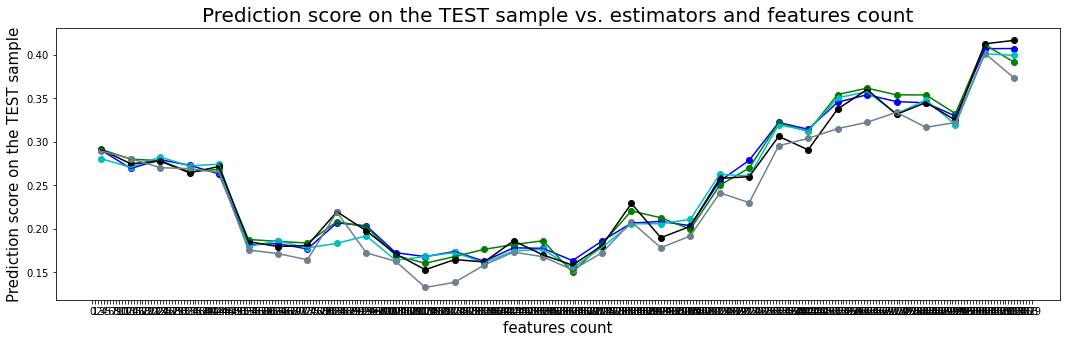

In [64]:
# wyrkes obrazujący jak zmienia sie dokładnośc predykcji w zależności od zastosowanych kolumn
rfr_results1_t100 = rfr_results1[rfr_results1['estimators'].isin(['100'])]
rfr_results1_t80 = rfr_results1[rfr_results1['estimators'].isin(['80'])]
rfr_results1_t70 = rfr_results1[rfr_results1['estimators'].isin(['70'])]
rfr_results1_t50 = rfr_results1[rfr_results1['estimators'].isin(['50'])]
rfr_results1_t20 = rfr_results1[rfr_results1['estimators'].isin(['20'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results1_t100['nfeatures'],rfr_results1_t100['test_score'], c='b' )
ax1.plot(rfr_results1_t100['nfeatures'],rfr_results1_t100['test_score'], c='b' )
ax1.scatter(rfr_results1_t80['nfeatures'],rfr_results1_t80['test_score'], c='g' )
ax1.plot(rfr_results1_t80['nfeatures'],rfr_results1_t80['test_score'], c='g' )
ax1.scatter(rfr_results1_t70['nfeatures'],rfr_results1_t70['test_score'], c='c' )
ax1.plot(rfr_results1_t70['nfeatures'],rfr_results1_t70['test_score'], c='c' )
ax1.scatter(rfr_results1_t50['nfeatures'],rfr_results1_t50['test_score'], c='k' )
ax1.plot(rfr_results1_t50['nfeatures'],rfr_results1_t50['test_score'], c='k' )
ax1.scatter(rfr_results1_t20['nfeatures'],rfr_results1_t20['test_score'], c='slategray' )
ax1.plot(rfr_results1_t20['nfeatures'],rfr_results1_t20['test_score'], c='slategray' )
ax1.axes.set_xticks(ind)
xlim=(2,23)
plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Wynik w zależności od zastosowanej ilosci drzew wydaje sie byc podobny, mimo wszystko najlepszy wynik w tej próbie został osiągnięty przu urzyciu 100 drzew oraz maksymalnej ilosci dostepnych zmiennych

# PCA

Sprawdze czy osiągnę lepszy wynik stosując PCA 


In [65]:
# przekształcam kolumnę z datą tak aby była interpretowalna dla standat scaller
braw['debut'] = pd.to_datetime(braw['debut'])
braw['debut']= braw['debut'].map(dt.datetime.toordinal)

In [66]:
X= braw.loc[:,(sorted_scores_list1[:])]
y= braw['points']

In [67]:
braw.loc[:,(sorted_scores_list1[:24])].head()

,MMA,division,KODPratio,rating_world_category,draws,age,defeats_by_KO,rating_native_category,last6,defeats,nationality,last5,career_period,last4,last3,last2,KODratio,last1,bouts,KOWPratio,KOWratio,wins_by_KO,last6Fwec,wins
2632,Y,super light,0.4211,1896,3.0,33.0,8.0,295,L,19.0,USA,W,3030,D,L,L,0.2105,L,38.0,0.5714,0.2105,8.0,11,14.0
2714,Y,super feather,0.0000,1400,1.0,30.0,0.0,182,L,3.0,USA,L,3009,W,L,W,0.0000,W,27.0,0.5217,0.4444,12.0,15,23.0
2955,Y,middle,0.3684,1367,1.0,30.0,7.0,251,L,19.0,USA,L,2869,L,L,L,0.2500,L,28.0,0.5000,0.1429,4.0,6,8.0
3052,Y,super light,0.5000,1896,2.0,36.0,5.0,295,L,10.0,USA,L,2799,L,L,NC,0.3571,L,14.0,0.0000,0.0000,0.0,6,1.0
3172,Y,welter,0.5000,1824,0.0,30.0,1.0,381,W,2.0,USA,L,3031,W,W,L,0.1000,W,10.0,0.6250,0.5000,5.0,18,8.0


In [68]:
braw_c= X.copy()
braw_c['division']= X['division'].astype('category').cat.codes
braw_c['MMA']= X['MMA'].astype('category').cat.codes
braw_c['last1']= X['last1'].astype('category').cat.codes
braw_c['last2']= X['last2'].astype('category').cat.codes
braw_c['last3']= X['last3'].astype('category').cat.codes
braw_c['last4']= X['last4'].astype('category').cat.codes
braw_c['last5']= X['last5'].astype('category').cat.codes
braw_c['last6']= X['last6'].astype('category').cat.codes
braw_c['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
braw_c['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
braw_c['nationality']= X['nationality'].astype('category').cat.codes
X= braw_c.copy()

In [69]:
# wprowadzam podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [70]:
# do normalizacji dla PCA posłużę sie metodą skalowania danych wykorzystującą bibliotekę StandardScaler
from sklearn.preprocessing import StandardScaler
X_train.astype('float')
# X_train.dropna(inplace=True)
X_train_s = StandardScaler(with_mean=False).fit_transform(X_train)
X_test_s = StandardScaler(with_mean=False).fit_transform(X_test)

In [71]:
X_train_s.shape

(6125, 24)

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.fit_transform(X_test_s)

In [73]:
np.min(X_train_pca)

-4.310328523782908

In [74]:
pca.explained_variance_ratio_

array([0.29318304, 0.17595678])

Text(0, 0.5, 'PC2')

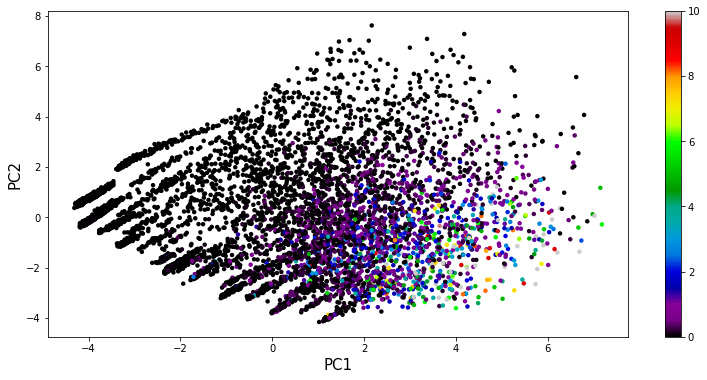

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,6))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], s=20, c = y_train, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
plt.clim(0,10)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)

Sprawdzam jak model Random Forest Regeressor zachowa się po normalizacji metodą PCA

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train_pca, y_train)
rfr_train_score = rfr.score(X_train_pca,y_train,sample_weight=None)
rfr_test_score = rfr.score(X_test_pca,y_test,sample_weight=None)
predicted = rfr.predict(X_test_pca)
mse_test= mean_squared_error(y_test, predicted)


In [77]:
print("rfr_train_score: ",rfr_train_score,"; rfr_test_score: ", rfr_test_score, "; mse_test: ", mse_test)

rfr_train_score:  0.889208638447552 ; rfr_test_score:  0.22994128405835823 ; mse_test:  2.0107155621587562


Jak widać model dalej jest przeuczony. Podejmę próbę zwiększenia estymatorów w PCA

In [78]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.fit_transform(X_test_s)

In [79]:
list(range(2,23))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [80]:
estimators= [10,20,50,70,80,100] # ilosc drzew w random forest
nfeatures = list(range(2,23)) # ilosc estymatorów PCA
rows3=[]
for j in nfeatures:
    pca = PCA(n_components=j)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca = pca.fit_transform(X_test_s)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train_pca, y_train)
        rfr_train_score = rfr.score(X_train_pca,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test_pca,y_test,sample_weight=None)
        predicted = rfr.predict(X_test_pca)
        mse_test= mean_squared_error(y_test, predicted)
        rows3.append([i,j, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results2= pd.DataFrame(rows3, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results2.sort_values(by="mse_test", ascending=True)

,estimators,nfeatures,train score,test_score,mse_test
53,100,10,0.904328,0.344747,1.710944
51,70,10,0.898397,0.337923,1.728763
52,80,10,0.905599,0.336237,1.733164
29,100,6,0.904021,0.332147,1.743845
28,80,6,0.904255,0.331940,1.744385
...,...,...,...,...,...
114,10,21,0.884515,0.184578,2.129164
108,10,20,0.889800,0.184303,2.129883
66,10,13,0.881323,0.177709,2.147101
84,10,16,0.871863,0.175553,2.152730


Text(0, 0.5, 'Prediction score on the TEST sample')

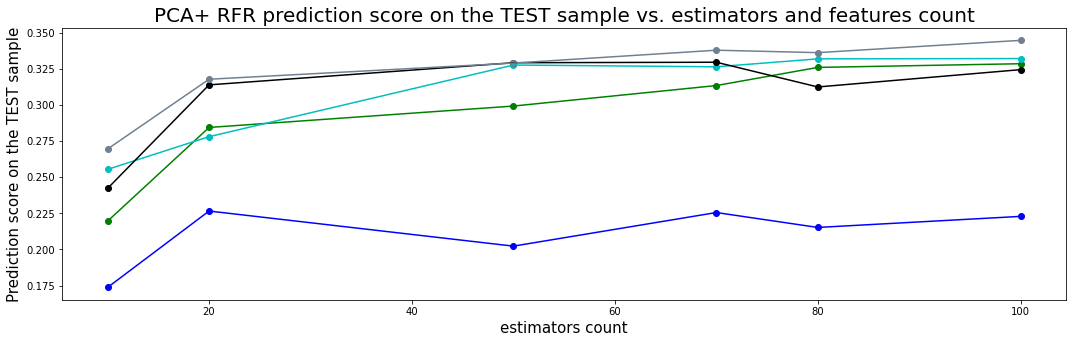

In [81]:
rfr_results3 = rfr_results2
rfr_results3_f2 = rfr_results3[rfr_results3['nfeatures'].isin(['2'])]
rfr_results3_f4 = rfr_results3[rfr_results3['nfeatures'].isin(['4'])]
rfr_results3_f6 = rfr_results3[rfr_results3['nfeatures'].isin(['6'])]
rfr_results3_f8 = rfr_results3[rfr_results3['nfeatures'].isin(['8'])]
rfr_results3_f10 = rfr_results3[rfr_results3['nfeatures'].isin(['10'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results3_f2['estimators'],rfr_results3_f2['test_score'], c='b' )
ax1.plot(rfr_results3_f2['estimators'],rfr_results3_f2['test_score'], c='b' )
ax1.scatter(rfr_results3_f4['estimators'],rfr_results3_f4['test_score'], c='g' )
ax1.plot(rfr_results3_f4['estimators'],rfr_results3_f4['test_score'], c='g' )
ax1.scatter(rfr_results3_f6['estimators'],rfr_results3_f6['test_score'], c='c' )
ax1.plot(rfr_results3_f6['estimators'],rfr_results3_f6['test_score'], c='c' )
ax1.scatter(rfr_results3_f8['estimators'],rfr_results3_f8['test_score'], c='k' )
ax1.plot(rfr_results3_f8['estimators'],rfr_results3_f8['test_score'], c='k' )
ax1.scatter(rfr_results3_f10['estimators'],rfr_results3_f10['test_score'], c='slategray' )
ax1.plot(rfr_results3_f10['estimators'],rfr_results3_f10['test_score'], c='slategray' )

plt.title("PCA+ RFR prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Text(0, 0.5, 'Prediction score on the TEST sample')

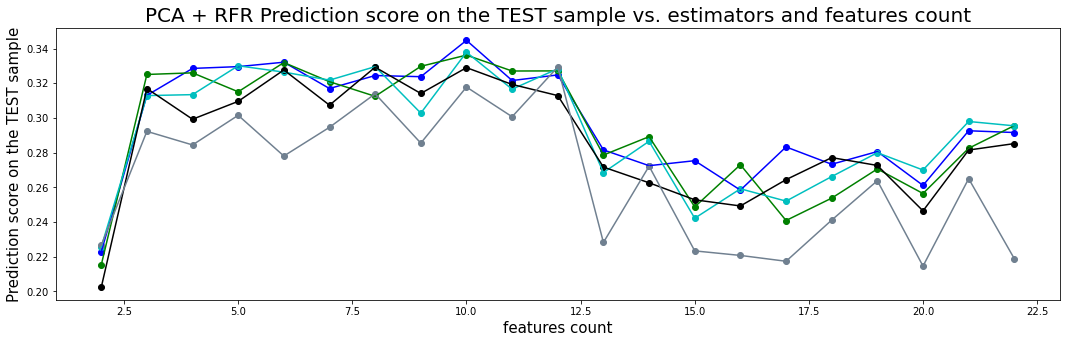

In [82]:
rfr_results3 = rfr_results2
rfr_results3_t100 = rfr_results3[rfr_results3['estimators'].isin(['100'])]
rfr_results3_t80 = rfr_results3[rfr_results3['estimators'].isin(['80'])]
rfr_results3_t70 = rfr_results3[rfr_results3['estimators'].isin(['70'])]
rfr_results3_t50 = rfr_results3[rfr_results3['estimators'].isin(['50'])]
rfr_results3_t20 = rfr_results3[rfr_results3['estimators'].isin(['20'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results3_t100['nfeatures'],rfr_results3_t100['test_score'], c='b' )
ax1.plot(rfr_results3_t100['nfeatures'],rfr_results3_t100['test_score'], c='b' )
ax1.scatter(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
ax1.plot(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
ax1.scatter(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
ax1.plot(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
ax1.scatter(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
ax1.plot(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
ax1.scatter(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
ax1.plot(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
# ax1.axes.set_xticks(ind)
# xlim=(2,23)
plt.title("PCA + RFR Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

PCA i RFR dało najlepszy wynik przy 18 wymiarach PCA i 50 drzewach RFR

# XGBoost

na koniec sprawdze jak z moimi danymi poradzi sobie XGBoost 

In [83]:
X= braw.loc[:,(sorted_scores_list1[:])]
y= braw['points']

# zamieniam kolumny na dane kategoryczne na potrzeby algorytmu scoringowego ważność poszczególnych kolumn

X['division']= X['division'].astype('category').cat.codes
X['MMA']= X['MMA'].astype('category').cat.codes
X['last1']= X['last1'].astype('category').cat.codes
X['last2']= X['last2'].astype('category').cat.codes
X['last3']= X['last3'].astype('category').cat.codes
X['last4']= X['last4'].astype('category').cat.codes
X['last5']= X['last5'].astype('category').cat.codes
X['last6']= X['last6'].astype('category').cat.codes
X['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
X['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
X['nationality']= X['nationality'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [84]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
predicted = model_xgb.predict(X_test)
mse_test= mean_squared_error(y_test, predicted)
print("xgb_train_score: ",xgb_train_score,"; xgb_test_score: ", xgb_test_score, "; mse_test: ", mse_test)

xgb_train_score:  0.9862590071944592 ; xgb_test_score:  0.38851171741771084 ; mse_test:  1.5966691635487167


In [85]:
# sprawdzam czy zastosowanie Encoder pomoże
# Wyznaczam target - wartością ktorą chcę przewidzieć jest rating z kolumny 'points'
X= braw.drop(['points', 'rating_native_position', 'rating_world_position','boxerID', 'debut', 'career edge','boxer'],axis=1)
y= braw['points']
Nc= ['age', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO','bouts', 'career_period','KOWratio', 'KOWPratio', 'KODratio',
       'KODPratio', 'last6Fwec']
XN = X.loc[:,Nc]
XC= X.drop(Nc,axis=1)
XCt= pd.get_dummies(XC)
Xt= XN.join(XCt)
Xt_arr= Xt.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size = 0.33, random_state = 42)

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
predicted = model_xgb.predict(X_test)
mse_test= mean_squared_error(y_test, predicted)
print("xgb_train_score: ",xgb_train_score,"; xgb_test_score: ", xgb_test_score, "; mse_test: ", mse_test)

xgb_train_score:  0.9574377028614186 ; xgb_test_score:  0.3742616807789212 ; mse_test:  1.6338777164003129


Encodowanie danych nie połomogo w poprawieniu wyniku

In [86]:
X= braw.loc[:,(sorted_scores_list1[:])]
y= braw['points']

# zamieniam kolumny na dane kategoryczne na potrzeby algorytmu scoringowego ważność poszczególnych kolumn

X['division']= X['division'].astype('category').cat.codes
X['MMA']= X['MMA'].astype('category').cat.codes
X['last1']= X['last1'].astype('category').cat.codes
X['last2']= X['last2'].astype('category').cat.codes
X['last3']= X['last3'].astype('category').cat.codes
X['last4']= X['last4'].astype('category').cat.codes
X['last5']= X['last5'].astype('category').cat.codes
X['last6']= X['last6'].astype('category').cat.codes
X['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
X['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
X['nationality']= X['nationality'].astype('category').cat.codes

In [87]:
brawx=X

In [88]:
# sprawdze z jaka iloscia X model bedzie najbardziej efektywny
# estimators= [10,20,50,70,80,100]
nfeatures = list(range(3,len(sorted_scores_list1)+1, 4))
rows4=[]
for j in nfeatures:
    X= brawx.loc[:,(sorted_scores_list1[:j]+['wins'])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    # normalizacja zmiennych za pomocą OneHotEncoder
#     ohe.fit(X_train)
#     X_train = ohe.transform(X_train)
#     X_test = ohe.transform(X_test)
    model_xgb = xgb.XGBRegressor(n_estimators=100)
    model_xgb.fit(X_train, y_train)
    xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
    xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
    predicted = model_xgb.predict(X_test)
    mse_test= mean_squared_error(y_test, predicted)
    rows4.append([j, xgb_train_score,xgb_test_score,mse_test])

    
xgb_results4= pd.DataFrame(rows4, columns= ['nfeatures','train score', 'test_score','mse_test'] )

In [89]:
xgb_results4.sort_values(by="mse_test", ascending=True)

,nfeatures,train score,test_score,mse_test
5,23,0.986259,0.388512,1.596669
3,15,0.974259,0.378502,1.622807
2,11,0.961378,0.375531,1.630563
4,19,0.982126,0.363505,1.661964
1,7,0.910958,0.237157,1.991875
0,3,0.745330,0.124577,2.285835


Jednak im wiecej tym lepiej...

Text(0, 0.5, 'Prediction score on the TEST sample')

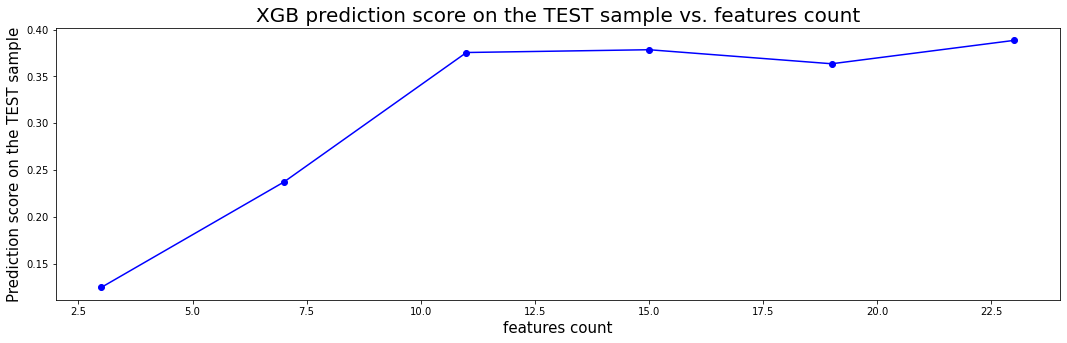

In [90]:
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(xgb_results4['nfeatures'],xgb_results4['test_score'], c='b' )
ax1.plot(xgb_results4['nfeatures'],xgb_results4['test_score'], c='b' )

# ax1.axes.set_xticks(ind)
# xlim=(2,25)
plt.title("XGB prediction score on the TEST sample vs. features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

In [91]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia estymatorów oraz jaka iloscia X model bedzie najbardziej efektywny
estimators= [10,20,50,70,80,100]
nfeatures = list(range(3,len(sorted_scores_list1)+1, 4))
rows5=[]
for j in nfeatures:
    X= brawx.loc[:,(sorted_scores_list1[:j]+['wins'])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    for i in estimators:
        model_xgb = xgb.XGBRegressor(n_estimators=i)
        model_xgb.fit(X_train, y_train)
        xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
        xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
        predicted = model_xgb.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)
        rows5.append([i,j, xgb_train_score,xgb_test_score,mse_test])

In [92]:
rfr_results5= pd.DataFrame(rows5, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results5.sort_values(by="mse_test", ascending=True)

,estimators,nfeatures,train score,test_score,mse_test
30,10,23,0.774214,0.414791,1.528051
13,20,11,0.799961,0.412086,1.535114
12,10,11,0.730198,0.411928,1.535525
19,20,15,0.837256,0.402385,1.560446
18,10,15,0.750876,0.402278,1.560724
31,20,23,0.863220,0.399910,1.566906
32,50,23,0.949242,0.396867,1.574853
33,70,23,0.969926,0.394703,1.580504
34,80,23,0.977324,0.389706,1.593550
14,50,11,0.906070,0.389412,1.594318


Text(0, 0.5, 'Prediction score on the TEST sample')

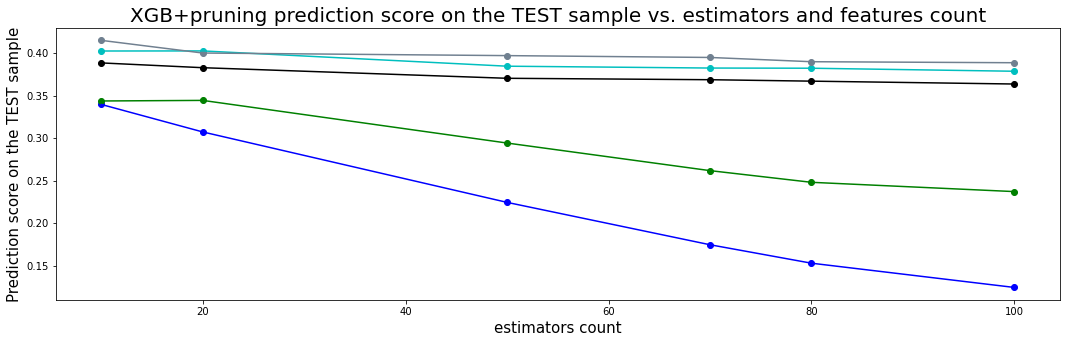

In [93]:
rfr_results5_f2 = rfr_results5[rfr_results5['nfeatures'].isin(['3'])]
rfr_results5_f4 = rfr_results5[rfr_results5['nfeatures'].isin(['7'])]
rfr_results5_f6 = rfr_results5[rfr_results5['nfeatures'].isin(['15'])]
rfr_results5_f8 = rfr_results5[rfr_results5['nfeatures'].isin(['19'])]
rfr_results5_f10 = rfr_results5[rfr_results5['nfeatures'].isin(['23'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results5_f2['estimators'],rfr_results5_f2['test_score'], c='b' )
ax1.plot(rfr_results5_f2['estimators'],rfr_results5_f2['test_score'], c='b' )
ax1.scatter(rfr_results5_f4['estimators'],rfr_results5_f4['test_score'], c='g' )
ax1.plot(rfr_results5_f4['estimators'],rfr_results5_f4['test_score'], c='g' )
ax1.scatter(rfr_results5_f6['estimators'],rfr_results5_f6['test_score'], c='c' )
ax1.plot(rfr_results5_f6['estimators'],rfr_results5_f6['test_score'], c='c' )
ax1.scatter(rfr_results5_f8['estimators'],rfr_results5_f8['test_score'], c='k' )
ax1.plot(rfr_results5_f8['estimators'],rfr_results5_f8['test_score'], c='k' )
ax1.scatter(rfr_results5_f10['estimators'],rfr_results5_f10['test_score'], c='slategray' )
ax1.plot(rfr_results5_f10['estimators'],rfr_results5_f10['test_score'], c='slategray' )

plt.title("XGB+pruning prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Text(0, 0.5, 'Prediction score on the TEST sample')

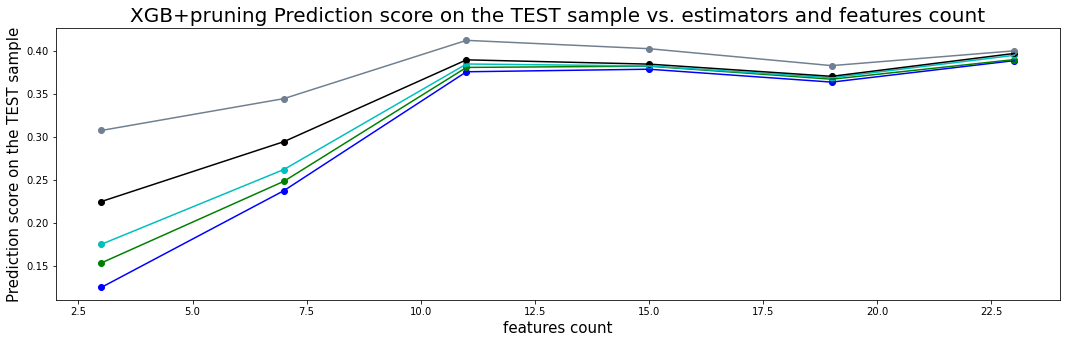

In [94]:
rfr_results5_t100 = rfr_results5[rfr_results5['estimators'].isin(['100'])]
rfr_results5_t80 = rfr_results5[rfr_results5['estimators'].isin(['80'])]
rfr_results5_t70 = rfr_results5[rfr_results5['estimators'].isin(['70'])]
rfr_results5_t50 = rfr_results5[rfr_results5['estimators'].isin(['50'])]
rfr_results5_t20 = rfr_results5[rfr_results5['estimators'].isin(['20'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results5_t100['nfeatures'],rfr_results5_t100['test_score'], c='b' )
ax1.plot(rfr_results5_t100['nfeatures'],rfr_results5_t100['test_score'], c='b' )
ax1.scatter(rfr_results5_t80['nfeatures'],rfr_results5_t80['test_score'], c='g' )
ax1.plot(rfr_results5_t80['nfeatures'],rfr_results5_t80['test_score'], c='g' )
ax1.scatter(rfr_results5_t70['nfeatures'],rfr_results5_t70['test_score'], c='c' )
ax1.plot(rfr_results5_t70['nfeatures'],rfr_results5_t70['test_score'], c='c' )
ax1.scatter(rfr_results5_t50['nfeatures'],rfr_results5_t50['test_score'], c='k' )
ax1.plot(rfr_results5_t50['nfeatures'],rfr_results5_t50['test_score'], c='k' )
ax1.scatter(rfr_results5_t20['nfeatures'],rfr_results5_t20['test_score'], c='slategray' )
ax1.plot(rfr_results5_t20['nfeatures'],rfr_results5_t20['test_score'], c='slategray' )
# ax1.axes.set_xticks(ind)
xlim=(2,23)
plt.title("XGB+pruning Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Wyniki wciąż nie sa zadowalające dlatego do kolejnego modelu wybieram kolumny wejsciowe według własnej intuicji.

In [95]:
adjusted_features = ['wins','defeats','draws','age','career_period','wins_by_KO','defeats_by_KO','last6Fwec','division','bouts']
list(range(2,len(adjusted_features)+1, 2))


[2, 4, 6, 8, 10]

In [96]:
brawx.loc[:,(adjusted_features[:15])].head()

,wins,defeats,draws,age,career_period,wins_by_KO,defeats_by_KO,last6Fwec,division,bouts
2632,14.0,19.0,3.0,33.0,3030,8.0,8.0,11,13,38.0
2714,23.0,3.0,1.0,30.0,3009,12.0,0.0,15,11,27.0
2955,8.0,19.0,1.0,30.0,2869,4.0,7.0,6,8,28.0
3052,1.0,10.0,2.0,36.0,2799,0.0,5.0,6,13,14.0
3172,8.0,2.0,0.0,30.0,3031,5.0,1.0,18,16,10.0


Ponownie wykonuje symulację sprawdzającą czy dobrane według mojej intuicji i ustawione przeze mnie w kolejności parametry wejscia poprawią jakość modelu.

In [97]:
estimators= [10,20,50,70,80,100]
nfeatures = list(range(2,len(adjusted_features)+1, 2))
rows7=[]
for j in nfeatures:
    X= brawx.loc[:,(adjusted_features[:j])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
#     # normalizacja zmiennych za pomocą OneHotEncoder
#     ohe.fit(X_train)
#     X_train = ohe.transform(X_train)
#     X_test = ohe.transform(X_test)
    for i in estimators:
        model_xgb = xgb.XGBRegressor(n_estimators=i)
        model_xgb.fit(X_train, y_train)
        xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
        xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
        predicted = model_xgb.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)    
        rows7.append([i,j, xgb_train_score,xgb_test_score,mse_test])

In [98]:
rfr_results7= pd.DataFrame(rows7, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results7.sort_values(by="mse_test", ascending=True)

,estimators,nfeatures,train score,test_score,mse_test
6,10,4,0.581615,0.400668,1.564929
0,10,2,0.475298,0.396919,1.574716
12,10,6,0.668288,0.388186,1.597520
7,20,4,0.641160,0.377028,1.626656
1,20,2,0.492837,0.374375,1.633582
24,10,10,0.727120,0.364866,1.658411
18,10,8,0.691517,0.364526,1.659299
13,20,6,0.767589,0.364472,1.659441
25,20,10,0.814728,0.339633,1.724297
19,20,8,0.788937,0.339208,1.725406


Text(0, 0.5, 'Prediction score on the TEST sample')

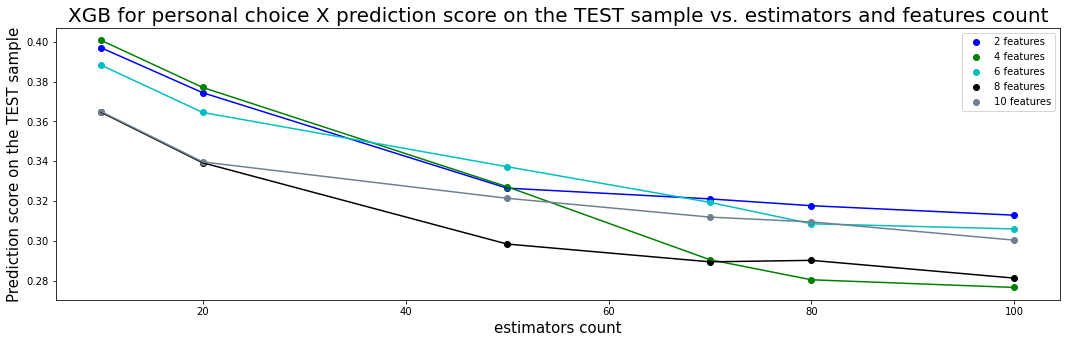

In [99]:
# wyrkes obrazujący jak zmienia sie dokładnośc predykcji w zależności od ilości drzew
rfr_results7_f12 = rfr_results7[rfr_results7['nfeatures'].isin(['2'])]
rfr_results7_f4 = rfr_results7[rfr_results7['nfeatures'].isin(['4'])]
rfr_results7_f16 = rfr_results7[rfr_results7['nfeatures'].isin(['6'])]
rfr_results7_f8 = rfr_results7[rfr_results7['nfeatures'].isin(['8'])]
rfr_results7_f20 = rfr_results7[rfr_results7['nfeatures'].isin(['10'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results7_f12['estimators'],rfr_results7_f12['test_score'], c='b' ,label='2 features')
ax1.plot(rfr_results7_f12['estimators'],rfr_results7_f12['test_score'], c='b' )
ax1.scatter(rfr_results7_f4['estimators'],rfr_results7_f4['test_score'], c='g' ,label='4 features')
ax1.plot(rfr_results7_f4['estimators'],rfr_results7_f4['test_score'], c='g' )
ax1.scatter(rfr_results7_f16['estimators'],rfr_results7_f16['test_score'], c='c' ,label='6 features')
ax1.plot(rfr_results7_f16['estimators'],rfr_results7_f16['test_score'], c='c' )
ax1.scatter(rfr_results7_f8['estimators'],rfr_results7_f8['test_score'], c='k' ,label='8 features')
ax1.plot(rfr_results7_f8['estimators'],rfr_results7_f8['test_score'], c='k' )
ax1.scatter(rfr_results7_f20['estimators'],rfr_results7_f20['test_score'], c='slategray' ,label='10 features')
ax1.plot(rfr_results7_f20['estimators'],rfr_results7_f20['test_score'], c='slategray' )
ax1.legend()
plt.title("XGB for personal choice X prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

Text(0, 0.5, 'Prediction score on the TEST sample')

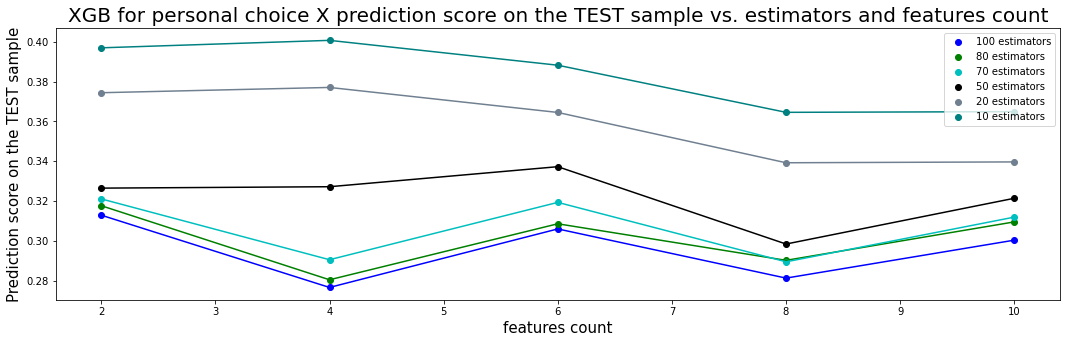

In [100]:
rfr_results7_t100 = rfr_results7[rfr_results7['estimators'].isin(['100'])]
rfr_results7_t80 = rfr_results7[rfr_results7['estimators'].isin(['80'])]
rfr_results7_t70 = rfr_results7[rfr_results7['estimators'].isin(['70'])]
rfr_results7_t50 = rfr_results7[rfr_results7['estimators'].isin(['50'])]
rfr_results7_t20 = rfr_results7[rfr_results7['estimators'].isin(['20'])]
rfr_results7_t10 = rfr_results7[rfr_results7['estimators'].isin(['10'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results7_t100['nfeatures'],rfr_results7_t100['test_score'], c='b', label='100 estimators' )
ax1.plot(rfr_results7_t100['nfeatures'],rfr_results7_t100['test_score'], c='b' )
ax1.scatter(rfr_results7_t80['nfeatures'],rfr_results7_t80['test_score'], c='g' , label='80 estimators')
ax1.plot(rfr_results7_t80['nfeatures'],rfr_results7_t80['test_score'], c='g' )
ax1.scatter(rfr_results7_t70['nfeatures'],rfr_results7_t70['test_score'], c='c' , label='70 estimators')
ax1.plot(rfr_results7_t70['nfeatures'],rfr_results7_t70['test_score'], c='c' )
ax1.scatter(rfr_results7_t50['nfeatures'],rfr_results7_t50['test_score'], c='k' , label='50 estimators')
ax1.plot(rfr_results7_t50['nfeatures'],rfr_results7_t50['test_score'], c='k' )
ax1.scatter(rfr_results7_t20['nfeatures'],rfr_results7_t20['test_score'], c='slategray' , label='20 estimators' )
ax1.plot(rfr_results7_t20['nfeatures'],rfr_results7_t20['test_score'], c='slategray' )
ax1.scatter(rfr_results7_t10['nfeatures'],rfr_results7_t10['test_score'], c='teal' , label='10 estimators' )
ax1.plot(rfr_results7_t10['nfeatures'],rfr_results7_t10['test_score'], c='teal' )
ax1.legend()
# ax1.axes.set_xticks(ind)
# xlim=(2,23)
plt.title("XGB for personal choice X prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

In [101]:
# Podsumowanie dla wszystkich zastosowanych metod 
# dodaje etykiety dla kazdej metody i łącze wyniki
rfr_results['label'] = "RFR" #first iteration random forest
rfr_results1['label'] = "RFR_MR" #mutual regression and random forest - redukcja wymiarow
rfr_results2['label'] = "RFR_PCA" #PCA i redukcja wymiarów oraz estymatorów
xgb_results4['label'] = "XGB_F" # XGB with limited number of features
rfr_results5['label'] = "XGB_FE" # XGB with limited number of features and reduced number of estimators
rfr_results7['label'] = "XGB_P" # XGB with features by according to my personal preferations  

In [102]:
r1= rfr_results[rfr_results['test_score']==rfr_results['test_score'].max()].drop_duplicates()
r2= rfr_results1[rfr_results1['test_score']==rfr_results1['test_score'].max()].drop_duplicates()
r3= rfr_results2[rfr_results2['test_score']==rfr_results2['test_score'].max()].drop_duplicates()
r4= xgb_results4[xgb_results4['test_score']==xgb_results4['test_score'].max()].drop_duplicates()
r5= rfr_results5[rfr_results5['test_score']==rfr_results5['test_score'].max()].drop_duplicates()
r6= rfr_results7[rfr_results7['test_score']==rfr_results7['test_score'].max()].drop_duplicates()
rmax= pd.concat([r1,r2,r3,r4,r5,r6]).sort_values(by="mse_test", ascending=True)
rmax

,estimators,train score,test_score,mse_test,label,nfeatures
0,100.0,0.912624,0.439395,1.463808,RFR,NaN
188,50.0,0.905125,0.416710,1.523039,RFR_MR,313.0
30,10.0,0.774214,0.414791,1.528051,XGB_FE,23.0
6,10.0,0.581615,0.400668,1.564929,XGB_P,4.0
5,NaN,0.986259,0.388512,1.596669,XGB_F,23.0
53,100.0,0.904328,0.344747,1.710944,RFR_PCA,10.0


Text(0, 0.5, 'Prediction score on the TEST sample')

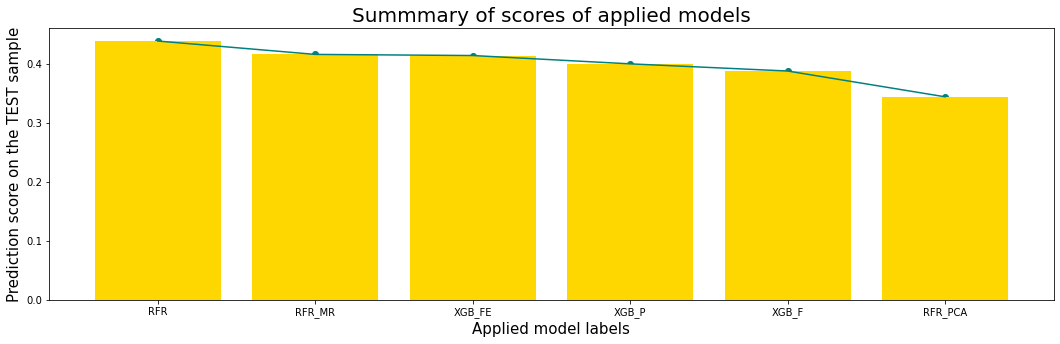

In [103]:
fig,ax1 = plt.subplots(figsize=(18, 5))

ax1.bar(rmax['label'],rmax['test_score'], color='gold' )
ax1.plot(rmax['label'],rmax['test_score'], c='teal' )
ax1.scatter(rmax['label'],rmax['test_score'], c='teal' )
# ax1.axes.set_xticks(ind)
# xlim=(2,23)
plt.title("Summmary of scores of applied models", size=20)
plt.xlabel("Applied model labels", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

# Podsumowanie
Szereg wykonanych modeli udowodnił ze uzycie zbyt duzej ilości danych nie prdzi do uzyskania predykcji na właściwym poziomie skuteczniści. Zadowalające wyniki na zbiorze treningowym nie mają przełożenia na skteczność przewidywania na zbiorze testowym. 
Świadczy to o przetrenowaniu modelu - model nie jest na tyle elastyczny aby dobrze przewidziec punktację w zbiorze testowym.
Analiza danych żadną z wybranych metod nie przyniosło oczekiwanego rezultatu. 

Zastosowane metody uczenia maszynowego:
- Regresja liniowa
- Random Forest Regressor (najlepszy wynik)
- Random Forest Regressor pruning - tworzenie modeli z ograniczoną liczbą estymatorów
- Random Forest Regressor pruning - testowanie modelu ograniczając liczbę estymatorów
- Mtual Info Regression - metora pozwalająca uszeregowanie dostepnych danych w kolejności od najniej do najbardziej skorelowanych. 
- Random Forest Regressor pruning + Mtual Info Regression
- Analiza Głownych Składowych (PCA) - redukcja wymiarow 
- PCA dla 2-22 wymiarów + Random Forest Regressor 
- XGBoost 
- XGBoost pruning 
- XGBoost pruning + Mtual Info Regression
- XGBoost pruning + personal choice

Najlepszy wynik udało osiągnąć dla modelu Random Fores Regressor przy 100 drzewach i wszystkich możliwych zmiennych. 